<a href="https://colab.research.google.com/github/schen304joseph/HW3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A12= 1.95841966952408
A21= 1.6891850023576693


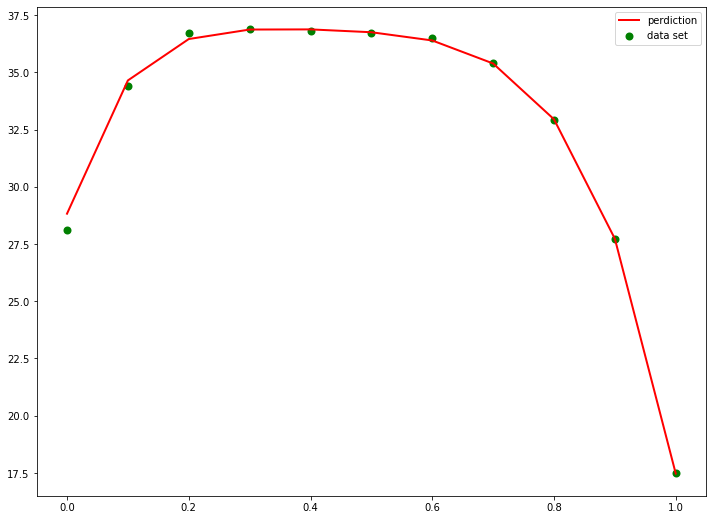

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

x1 = np.arange(start=0, stop=1.1, step=0.1)
p = np.array([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])

def psat (a1,a2,a3):
  return 10**(a1-(a2/(20+a3)))

def pval (x1,A12,A21):
  x2 = 1-x1
  return x1*np.exp(A12*((A21*x2)/(A12*x1+A21*x2))**2)*psat(8.07131,1730.63,233.426)+x2*np.exp(A21*((A12*x1)/(A12*x1+A21*x2))**2)*psat(7.43155,1554.679,240.337)

c, cov = curve_fit(pval,x1,p)

n = len(x1)
y=np.empty(n)
for i in range(n):
  y[i]=pval(x1[i],c[0],c[1])

plt.scatter(x1,p,color="green",label="data set",linewidth=2)
plt.plot(x1,y,color="red",label="perdiction",linewidth=2)
plt.legend()
print("A12=",c[0])
print("A21=",c[1])

In [41]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior


class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API
    
    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
from botorch.fit import fit_gpytorch_model

def _get_and_fit_simple_custom_gp(Xs, Ys, **kwargs):
    model = SimpleCustomGP(Xs[0], Ys[0])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

import random
import numpy as np

def branin(parameterization, *args):
    x1, x2 = parameterization["x1"], parameterization["x2"]
    y = (x2 - 5.1 / (4 * np.pi ** 2) * x1 ** 2 + 5 * x1 / np.pi - 6) ** 2
    y += 10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10
    # let's add some synthetic observation noise
    y += random.normalvariate(0, 0.1)
    return {"branin": (y, 0.0)}

from ax import ParameterType, RangeParameter, SearchSpace

search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name="x1", parameter_type=ParameterType.FLOAT, lower=-5, upper=10
        ),
        RangeParameter(
            name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=15
        ),
    ]
)

from ax import SimpleExperiment

exp = SimpleExperiment(
    name="test_branin",
    search_space=search_space,
    evaluation_function=branin,
    objective_name="branin",
    minimize=True,
)

from ax.modelbridge import get_sobol

sobol = get_sobol(exp.search_space)
exp.new_batch_trial(generator_run=sobol.gen(5))

from ax.modelbridge.factory import get_botorch

for i in range(5):
    print(f"Running optimization batch {i+1}/5...")
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=_get_and_fit_simple_custom_gp,)
    batch = exp.new_trial(generator_run=model.gen(1))
    
print("Done!")

Running optimization batch 1/5...
Running optimization batch 2/5...
Running optimization batch 3/5...
Running optimization batch 4/5...
Running optimization batch 5/5...
Done!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)


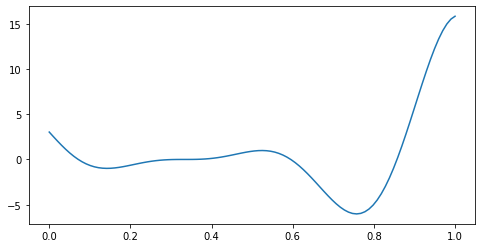

In [4]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)

def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

x = torch.linspace(0, 1)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

X = torch.tensor([0.0, 0.33, 0.66, 1.0])
y = f(X)
gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1),noise=torch.tensor(0.1), jitter=1.0e-4)

def update_posterior(x_new):
    y = f(x_new) # evaluate f at new point.
    X = torch.cat([gpmodel.X, x_new]) # incorporate new evaluation
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)